This image is : <class 'numpy.ndarray'> with width : 960 and height : 540


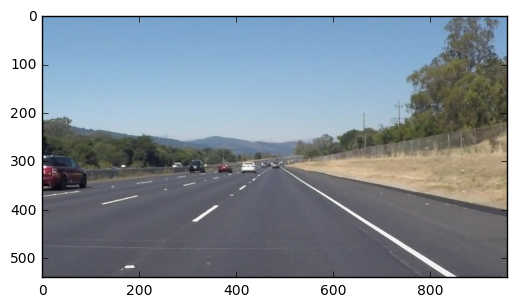

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy import *

image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is :',type(image),'with width :',image.shape[1],'and height :',image.shape[0])
plt.imshow(image)
plt.show()

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


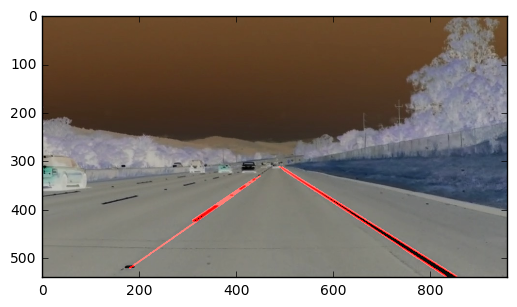

NameError: name 'VideoFileClip' is not defined

In [11]:

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)
    
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask  = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines , color = [255, 0, 0], thickness = 2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta,threshold, np.array([]), min_line_len, max_line_gap)
    #line_img = np.zeros((*img.shape,3), dtype = np.uint8)
    line_img = np.zeros(img.shape + (3,), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, alpha = 0.8, beta = 1.0, lambda1 = 0.0):
    return cv2.addWeighted(initial_img,alpha,img, beta,lambda1)

def process_image(image):
    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    # plt.imshow(blur_gray, cmap='gray')

    # Define our parameters for Canny and apply
    low_threshold = 45 #50
    high_threshold = 150 #150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(475, 310), (475, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15# minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line 150 - 40
    max_line_gap = 130 # maximum gap in pixels between connectable line segments 58 -95
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, image)
    return lines_edges

def main():
    # reading in an image
    image = (mpimg.imread('test_images/solidWhiteRight.jpg') * 255).astype('uint8')
    #image = (mpimg.imread('test_images/solidWhiteCurve.jpg') * 255).astype('uint8')
    #image = (mpimg.imread('test_images/solidYellowCurve.jpg') * 255).astype('uint8')
    #image = (mpimg.imread('test_images/solidYellowCurve2.jpg') * 255).astype('uint8')
    #image = (mpimg.imread('test_images/solidYellowLeft.jpg') * 255).astype('uint8')
    #image = (mpimg.imread('test_images/whiteCarLaneSwitch.jpg') * 255).astype('uint8')
    processImage = process_image(image)
    plt.imshow(processImage)
    plt.show()

    # Make video
    white_output = 'white.mp4'
    clip1 = VideoFileClip("solidWhiteRight.MP4")
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)

    # Make video
    yellow_output = 'yellow.mp4'
    clip2 = VideoFileClip('solidYellowLeft.mp4')
    yellow_clip = clip2.fl_image(process_image)
    yellow_clip.write_videofile(yellow_output, audio=False)

if __name__ == '__main__':
    main()